# Setting the environment for Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/github_repo/w266_final/project_re"

/content/drive/.shortcut-targets-by-id/1kzskPlOj9PLeYfK_UrNXwaloxbg5EzRW/github_repo/w266_final/project_re


In [ ]:
!pip install transformers

In [ ]:
import torch
import pickle, copy
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss, KLDivLoss

import importlib
from model.MedClinical import Biobert_fc 


from tqdm import tqdm_notebook, trange
import os
from transformers import BertTokenizer, BertModel
from transformers import  BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from transformers.optimization import AdamW
from torch.optim import lr_scheduler
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

from multiprocessing import Pool, cpu_count
from util.tools  import *
from util import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Preparing  the data
- Grab random sample of 1000 observations to make sure code runs. (optional)
- Split train dataset into train and dev set 

### Random sampling for testing and iterating on BERT setup efficiently

In [ ]:
import pandas
import random

n = 76318 #number of records in file
s = 1250 #desired sample size (to later obtain a train/dev split of 80/20)
#train_file = "data/train.tsv"

#skip = sorted(random.sample(range(n),n-s))
#train_df = pandas.read_csv(train_file, sep = "\t", skiprows=skip, header= None)

In [ ]:
#train_df.head()

,0,1,2,3
0,98,3,a,3. OBJ_B acetaminophen OBJ_E 325 mg Tablet Sig...
1,170,5,a,16. OBJ_B topiramate OBJ_E 25 mg SUB_B Tablet ...
2,201,0,a,On hospital day 11 he had a witnessed SUB_B gr...
3,305,8,a,The basilar cisterns are not compressed.
4,344,8,a,# Ventilator associated pneumonia: Patient de...


### Splitting train into train and dev

In [ ]:
#import numpy as np
#msk = np.random.rand(len(train_df)) < 0.8
#train = train_df[msk]
#dev = train_df[~msk]
#print(len(train))
#print(len(dev))

1047
203


In [ ]:
#train.to_csv("data_subset/train.tsv", sep = '\t', index=False, header=False)
#dev.to_csv("data_subset/dev.tsv", sep = '\t', index=False, header=False)

### Hyper parameters

In [ ]:
 # -1 is not freezing any layers
NUM_BERT_LAYERS_FREEZE = -1

# Maximum sequence Length
MAX_SEQ_LENGTH = 128 

#options are AdamW, SGD, 
optimizer = 'AdamW'

# Batch Sizes
TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8

# Learning Rate - most important setting
LEARNING_RATE = 1e-5


# Number of iterations over training set
NUM_TRAIN_EPOCHS = 10

# This is used for learning rate optimization scheduler
num_warmup_steps = 100

GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1

Scheduler_step_size = 1

# Use below setting for GPU, other wise set it to False
pin_memory=True

# This is used multi processing while data loading
num_workers = 4

### Define Other configuration settings

In [ ]:
# Change this directory depending on whether sample or full data should be used
DATA_DIR = "data_subset/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'Relation Extraction'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.


RANDOM_SEED = 42
CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

### Create Directories, if doesn't exist

In [ ]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)
    
# if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
#         raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
processor = MultiClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [ ]:
train_examples_len

1047

In [ ]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_labels, label_list

(9,
 ['Reason-Drug',
  'Route-Drug',
  'Strength-Drug',
  'Frequency-Drug',
  'Duration-Drug',
  'Form-Drug',
  'Dosage-Drug',
  'ADE-Drug',
  'no relation'])

In [ ]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS
num_train_optimization_steps

430

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
train_examples_for_processing = [(example,  MAX_SEQ_LENGTH, tokenizer) for example in train_examples]
len(train_examples_for_processing)

1047

### Convert Inputs to features in parallel threads -- Below 2 cells are commented, as it is needed only one time. We will use cached file from second time onwards

In [ ]:
#process_count = cpu_count() - 1
#with Pool(process_count) as p:
#    train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#with open(DATA_DIR + "train_features.pkl", "wb") as f:
#    pickle.dump(train_features, f)

In [ ]:
with open(DATA_DIR + "train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

In [ ]:
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

model = Biobert_fc()

In [ ]:
x = model.to(device)

#### Freezing pretrained Transformer Layers

In [ ]:
if NUM_BERT_LAYERS_FREEZE >= 0:
    count = 0 
    for child in model.children():
        count+=1
        if count < NUM_BERT_LAYERS_FREEZE:
            for param in child.parameters():
                param.requires_grad = False

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
# param_optimizer

In [ ]:
optimizer     = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps =num_train_optimization_steps)  # PyTorch scheduler
# scheduler = lr_scheduler.StepLR( optimizer, step_size=Scheduler_step_size, gamma=0.1)

In [ ]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [ ]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([int(f.label_id) for f in train_features], dtype=torch.long)
# all_label_ids


INFO:root:***** Running training *****
INFO:root:  Num examples = 1047
INFO:root:  Batch size = 24
INFO:root:  Num steps = 430


In [ ]:
# torch.tensor([f.label_id for f in train_features])

In [ ]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [ ]:
def train_model(model,optimizer, scheduler, train_dataloader, device, num_epochs=25, GRADIENT_ACCUMULATION_STEPS = 1 ):

    model = model.to(device)
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()
    for epoch in trange(int(num_epochs), desc="Epoch"):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        running_loss = 0.0
        running_corrects = 0

        for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
            scheduler.step()
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

    #         logits = model(input_ids, segment_ids, input_mask, labels=None)
            logits = model(input_ids, segment_ids, input_mask)
            
            loss_fct = CrossEntropyLoss()
#             loss_fct = KLDivLoss(reduction = 'batchmean')
#             print('predict vs label', logits.view(-1, num_labels),label_ids.view(-1) )
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

            if GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / GRADIENT_ACCUMULATION_STEPS

            loss.backward()
            print("\r loss %f" %  loss, end='')

            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1

            running_loss += loss.item() * nb_tr_examples
#             running_corrects += torch.sum(logits.view(-1, num_labels) == label_ids.view(-1))
            
            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

        epoch_loss = running_loss /TRAIN_BATCH_SIZE
#         epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)
    
        epoch_acc = -1
    
        print('epoch: {:d} Loss: {:.4f} Acc: {:.4f}'.format(
            epoch, epoch_loss, epoch_acc))

        if  epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete')
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
# from train import train_model
model = train_model(model,  optimizer, scheduler, train_dataloader, device = device, num_epochs=NUM_TRAIN_EPOCHS)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 loss 1.845069

Epoch:  10%|█         | 1/10 [19:10<2:52:33, 1150.40s/it]


epoch: 0 Loss: 1961.2671 Acc: -1.0000


 loss 1.332549

Epoch:  20%|██        | 2/10 [37:45<2:31:57, 1139.69s/it]


epoch: 1 Loss: 1411.9727 Acc: -1.0000


 loss 0.753144

Epoch:  30%|███       | 3/10 [56:41<2:12:50, 1138.68s/it]


epoch: 2 Loss: 996.4019 Acc: -1.0000


 loss 0.863451

Epoch:  40%|████      | 4/10 [1:14:11<1:51:13, 1112.17s/it]


epoch: 3 Loss: 857.6671 Acc: -1.0000


 loss 0.725694

Epoch:  50%|█████     | 5/10 [1:31:15<1:30:28, 1085.65s/it]


epoch: 4 Loss: 723.0967 Acc: -1.0000


 loss 0.536272

Epoch:  60%|██████    | 6/10 [1:48:50<1:11:45, 1076.47s/it]


epoch: 5 Loss: 561.1033 Acc: -1.0000


 loss 0.543614

Epoch:  70%|███████   | 7/10 [2:05:56<53:04, 1061.38s/it]  


epoch: 6 Loss: 420.9323 Acc: -1.0000


 loss 0.429563

Epoch:  80%|████████  | 8/10 [2:22:40<34:48, 1044.20s/it]


epoch: 7 Loss: 361.1059 Acc: -1.0000


 loss 0.244376

Epoch:  90%|█████████ | 9/10 [2:39:28<17:13, 1033.14s/it]


epoch: 8 Loss: 308.4737 Acc: -1.0000


 loss 0.374497

Epoch: 100%|██████████| 10/10 [2:56:32<00:00, 1059.20s/it]


epoch: 9 Loss: 299.0725 Acc: -1.0000
Training complete
Best val Acc: 0.000000


In [ ]:
# model.train()
# for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
#     tr_loss = 0
#     nb_tr_examples, nb_tr_steps = 0, 0
#     for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
#         scheduler.step()
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, input_mask, segment_ids, label_ids = batch

# #         logits = model(input_ids, segment_ids, input_mask, labels=None)
#         logits = model(input_ids, segment_ids, input_mask)

#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

#         if GRADIENT_ACCUMULATION_STEPS > 1:
#             loss = loss / GRADIENT_ACCUMULATION_STEPS

#         loss.backward()
#         print("\r%f" % loss, end='')
        
#         tr_loss += loss.item()
#         nb_tr_examples += input_ids.size(0)
#         nb_tr_steps += 1
#         if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
#             optimizer.step()
#             optimizer.zero_grad()
#             global_step += 1

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
torch.save(model, OUTPUT_DIR + 'best_mdel')
# model_to_save.config.to_json_file(output_config_file)
# tokenizer.save_vocabulary(OUTPUT_DIR)

## Now, let us evaluate on Training Set

In [ ]:
# model = Biobert_fc()
# # model =  BertModel.from_pretrained((BERT_MODEL))
# path = OUTPUT_DIR +  'pytorch_model.bin'
# model.load_state_dict(torch.load(path))
# x = model.to(device)
# model.eval()

In [ ]:
import numpy as np
model.eval()
train_loss = 0
nb_train_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(train_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask)

    # create eval loss and other metric required by the task
    loss_fct = CrossEntropyLoss()
    tmp_train_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

    train_loss += tmp_train_loss.mean().item()

    nb_train_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

train_loss = train_loss / nb_train_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
len(preds), len(all_label_ids)

(1047, 1047)

In [ ]:
import json
CONFIG_FOLDER = 'config/'
id_label_file = 'id_2_label.json'
with open(CONFIG_FOLDER + id_label_file) as infile:
    id2label = json.load(infile)

In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

preds_labels = [id2label[str(p)] for p in preds]
all_labels =  [id2label[str(l)] for l in all_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

Correlation Coefficient is  -0.008179126475088803


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


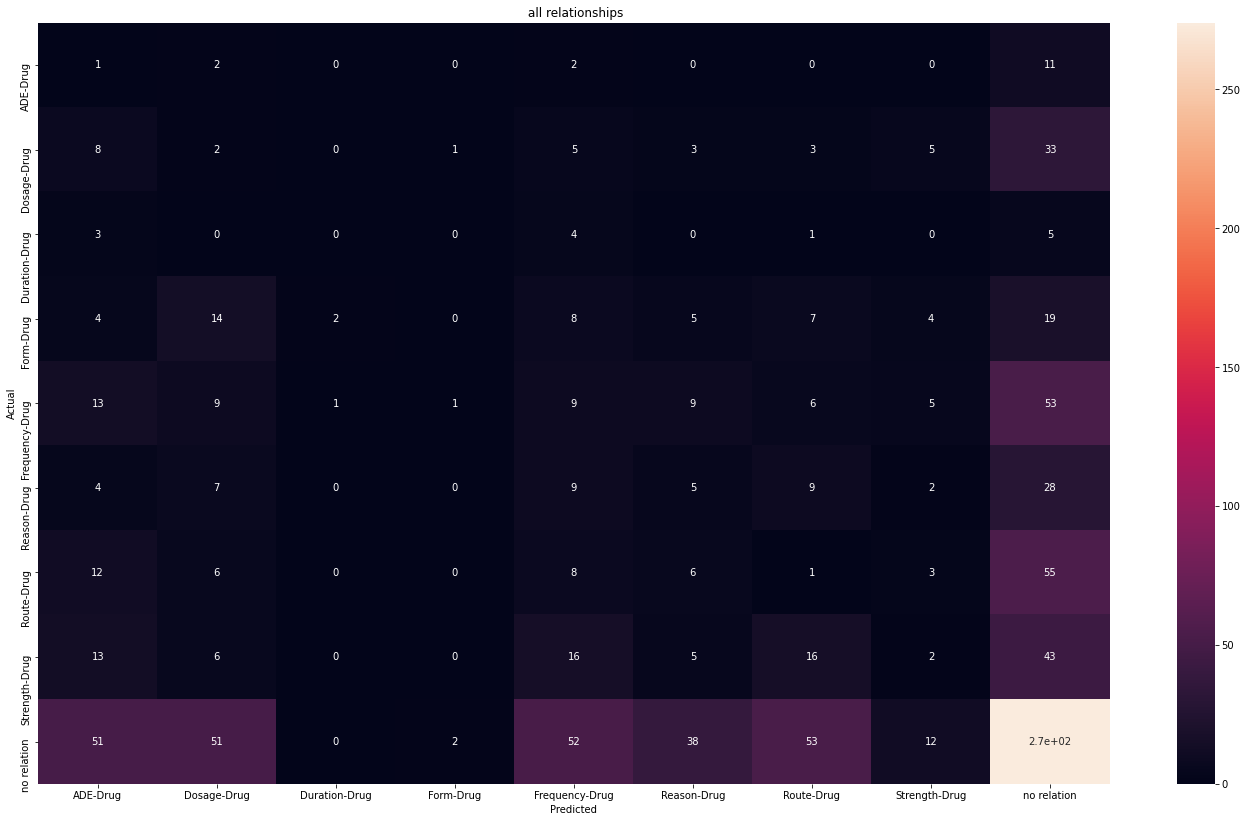

In [ ]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()


In [ ]:
# confusion_matrix.to_csv('test')

In [ ]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.2808022922636103

In [ ]:
df["matched"] = df["labels"] == df["predicted"]
# df["nomatch"] = df["labels"] != df["predicted"]
df.groupby(["labels", "matched"]).count()

predicted
labels         matched           
ADE-Drug       False           15
               True             1
Dosage-Drug    False           58
               True             2
Duration-Drug  False           13
Form-Drug      False           63
Frequency-Drug False           97
               True             9
Reason-Drug    False           59
               True             5
Route-Drug     False           90
               True             1
Strength-Drug  False           99
               True             2
no relation    False          259
               True           274